In [33]:
import numpy as np
import torch

In [34]:
# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)  # reproducible sampling

**1D function example**: Forrester et al. (2008)

$f(x) = (6x - 2)^2 \sin(12x - 4)$

In [35]:
# function to learn (normally a high-dimensional, expensive deterministic model)
from GPErks.utils.test_functions import forrester
f = lambda x: forrester(x)
D = 1

In [36]:
# build dataset
from GPErks.gp.data.dataset import Dataset
dataset = Dataset.build_from_function(
    f,
    D,
    n_train_samples=10,
    n_test_samples=10,
    design="srs",
    seed=seed,
    l_bounds=[0],
    u_bounds=[1]  # can put None if, as in this case, parameters range in [0, 1]
)

In [37]:
# choose likelihood
from gpytorch.likelihoods import GaussianLikelihood
likelihood = GaussianLikelihood()

In [38]:
# choose mean function
from gpytorch.means import LinearMean
mean_function = LinearMean(input_size=dataset.input_size)

In [39]:
# choose covariance function (kernel)
from gpytorch.kernels import RBFKernel, ScaleKernel
kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))

In [40]:
# choose metrics
from torchmetrics import MeanSquaredError, R2Score
metrics = [MeanSquaredError(), R2Score()]

In [41]:
# define experiment
from GPErks.gp.experiment import GPExperiment
experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed,  # reproducible training
    learn_noise=True
)

In [42]:
# choose training options: device + optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)

In [43]:
# train model
from GPErks.train.emulator import GPEmulator
emulator = GPEmulator(experiment, device)
emulator.train(optimizer)

INFO:2021-08-03 18:15:46,686:emulator:train:L83: Training emulator...
INFO:2021-08-03 18:15:46,688:emulator:train:L99: Running restart 1...
/home/sl18/Documents/Python/GPErks/venv/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:282: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2021-08-03 18:15:46,709:emulator:_train_once:L308: [  1/100] Training Loss: 1.6861 - MeanSquaredError: 0.8620 - R2Score: 0.1380
INFO:2021-08-03 18:15:46,715:emulator:_train_once:L308: [  2/100] Training Loss: 1.6591 - MeanSquaredError: 0.8447 - R2Score: 0.1553
INFO:2021-08-03 18:15:46,723:emulator:_train_once:L308: [  3/100] Training Loss: 1.6330 - MeanSquaredError: 0.8289 - R2Score: 0.1711
INFO:2021-08-03 18:15:46,730:emulator:_train_once:L308: [  4/100] Training Loss: 1.6080 - MeanSquaredError: 0.8145 - R2Score: 0.1855
INFO:2021-08-03 18:15:46,737:emulator:_train_once:L308: [  5/100] Training Loss: 1.5840 - MeanSquaredError: 0.80

INFO:2021-08-03 18:15:47,067:emulator:_train_once:L308: [ 60/100] Training Loss: 1.2886 - MeanSquaredError: 0.7543 - R2Score: 0.2457
INFO:2021-08-03 18:15:47,073:emulator:_train_once:L308: [ 61/100] Training Loss: 1.2881 - MeanSquaredError: 0.7541 - R2Score: 0.2459
INFO:2021-08-03 18:15:47,078:emulator:_train_once:L308: [ 62/100] Training Loss: 1.2874 - MeanSquaredError: 0.7539 - R2Score: 0.2461
INFO:2021-08-03 18:15:47,084:emulator:_train_once:L308: [ 63/100] Training Loss: 1.2867 - MeanSquaredError: 0.7540 - R2Score: 0.2460
INFO:2021-08-03 18:15:47,091:emulator:_train_once:L308: [ 64/100] Training Loss: 1.2863 - MeanSquaredError: 0.7542 - R2Score: 0.2458
INFO:2021-08-03 18:15:47,096:emulator:_train_once:L308: [ 65/100] Training Loss: 1.2860 - MeanSquaredError: 0.7542 - R2Score: 0.2458
INFO:2021-08-03 18:15:47,101:emulator:_train_once:L308: [ 66/100] Training Loss: 1.2856 - MeanSquaredError: 0.7540 - R2Score: 0.2460
INFO:2021-08-03 18:15:47,109:emulator:_train_once:L308: [ 67/100] Tra

INFO:2021-08-03 18:15:47,401:emulator:_train_once:L308: [ 21/100] Training Loss: 1.3417 - MeanSquaredError: 0.4408 - R2Score: 0.5592
INFO:2021-08-03 18:15:47,407:emulator:_train_once:L308: [ 22/100] Training Loss: 1.3187 - MeanSquaredError: 0.3907 - R2Score: 0.6093
INFO:2021-08-03 18:15:47,411:emulator:_train_once:L308: [ 23/100] Training Loss: 1.2971 - MeanSquaredError: 0.3441 - R2Score: 0.6559
INFO:2021-08-03 18:15:47,415:emulator:_train_once:L308: [ 24/100] Training Loss: 1.2791 - MeanSquaredError: 0.3052 - R2Score: 0.6948
INFO:2021-08-03 18:15:47,421:emulator:_train_once:L308: [ 25/100] Training Loss: 1.2662 - MeanSquaredError: 0.2755 - R2Score: 0.7245
INFO:2021-08-03 18:15:47,425:emulator:_train_once:L308: [ 26/100] Training Loss: 1.2584 - MeanSquaredError: 0.2517 - R2Score: 0.7483
INFO:2021-08-03 18:15:47,430:emulator:_train_once:L308: [ 27/100] Training Loss: 1.2524 - MeanSquaredError: 0.2288 - R2Score: 0.7712
INFO:2021-08-03 18:15:47,435:emulator:_train_once:L308: [ 28/100] Tra

INFO:2021-08-03 18:15:47,718:emulator:_train_once:L308: [ 83/100] Training Loss: -0.0197 - MeanSquaredError: 0.0000 - R2Score: 1.0000
INFO:2021-08-03 18:15:47,724:emulator:_train_once:L308: [ 84/100] Training Loss: -0.0243 - MeanSquaredError: 0.0000 - R2Score: 1.0000
INFO:2021-08-03 18:15:47,730:emulator:_train_once:L308: [ 85/100] Training Loss: -0.0282 - MeanSquaredError: 0.0000 - R2Score: 1.0000
INFO:2021-08-03 18:15:47,735:emulator:_train_once:L308: [ 86/100] Training Loss: -0.0314 - MeanSquaredError: 0.0000 - R2Score: 1.0000
INFO:2021-08-03 18:15:47,741:emulator:_train_once:L308: [ 87/100] Training Loss: -0.0350 - MeanSquaredError: 0.0000 - R2Score: 1.0000
INFO:2021-08-03 18:15:47,746:emulator:_train_once:L308: [ 88/100] Training Loss: -0.0377 - MeanSquaredError: 0.0000 - R2Score: 1.0000
INFO:2021-08-03 18:15:47,752:emulator:_train_once:L308: [ 89/100] Training Loss: -0.0401 - MeanSquaredError: 0.0000 - R2Score: 1.0000
INFO:2021-08-03 18:15:47,758:emulator:_train_once:L308: [ 90/1

INFO:2021-08-03 18:15:48,063:emulator:_train_once:L308: [ 44/100] Training Loss: 1.3095 - MeanSquaredError: 0.7547 - R2Score: 0.2453
INFO:2021-08-03 18:15:48,069:emulator:_train_once:L308: [ 45/100] Training Loss: 1.3065 - MeanSquaredError: 0.7544 - R2Score: 0.2456
INFO:2021-08-03 18:15:48,074:emulator:_train_once:L308: [ 46/100] Training Loss: 1.3045 - MeanSquaredError: 0.7549 - R2Score: 0.2451
INFO:2021-08-03 18:15:48,079:emulator:_train_once:L308: [ 47/100] Training Loss: 1.3033 - MeanSquaredError: 0.7559 - R2Score: 0.2441
INFO:2021-08-03 18:15:48,085:emulator:_train_once:L308: [ 48/100] Training Loss: 1.3026 - MeanSquaredError: 0.7567 - R2Score: 0.2433
INFO:2021-08-03 18:15:48,091:emulator:_train_once:L308: [ 49/100] Training Loss: 1.3019 - MeanSquaredError: 0.7570 - R2Score: 0.2430
INFO:2021-08-03 18:15:48,097:emulator:_train_once:L308: [ 50/100] Training Loss: 1.3007 - MeanSquaredError: 0.7566 - R2Score: 0.2434
INFO:2021-08-03 18:15:48,102:emulator:_train_once:L308: [ 51/100] Tra


Bias: -1.0693
Weights: 2.9473683834075928
Outputscale: 1.8783
Lengthscales: 0.18385031819343567
Likelihood noise: 0.0001


(OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-10.7608])),
              ('mean_module.weights', tensor([[2.9474]])),
              ('mean_module.bias', tensor([-1.0693])),
              ('covar_module.raw_outputscale', tensor(1.7124)),
              ('covar_module.base_kernel.raw_lengthscale',
               tensor([[-1.6003]]))]),
 <GPErks.train.train_stats.TrainStats at 0x7f6cba4aaa30>)

In [44]:
# inference on stored test set
x_test = dataset.X_test
y_test = dataset.y_test

y_mean, y_std = emulator.predict(x_test)

for metric in metrics:
    print( metric(
        torch.from_numpy(y_mean), torch.from_numpy(y_test)
        ).item()
    )

0.2553609013557434
0.8388262391090393


In [45]:
# perk n.1: automatic inference
from GPErks.perks.inference import Inference
inference = Inference(emulator)
inference.summary()  # can be retrieved from inference.scores_dct

                   Score
MeanSquaredError  0.2554
R2Score           0.8388


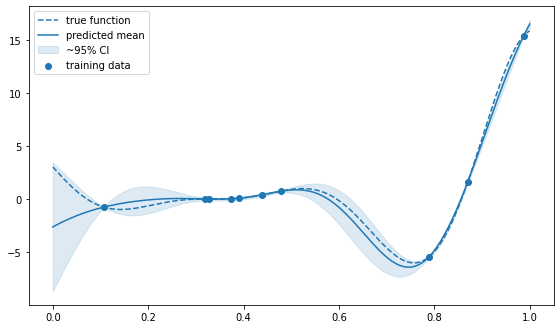

In [46]:
# nice plotting
x_train = dataset.X_train
y_train = dataset.y_train

xx = np.linspace(dataset.l_bounds[0], dataset.u_bounds[0], 1000)
yy_mean, yy_std = emulator.predict(xx)
yy_true = f(xx)

import matplotlib.pyplot as plt
height = 9.36111
width = 5.91667
fig, axis = plt.subplots(1, 1, figsize=(4*width/3, height/2))

axis.plot(xx, yy_true, c="C0", ls="--", label="true function")

CI = 2
axis.plot(xx, yy_mean, c="C0", label="predicted mean")
axis.fill_between(
    xx, yy_mean - CI * yy_std, yy_mean + CI * yy_std, color="C0", alpha=0.15, label="~95% CI"
)
axis.scatter(x_train, y_train, fc="C0", ec="C0", label="training data")

# axis.scatter(x_test, y_test, fc="none", ec="C0", label="testing data")

axis.legend(loc="best")
fig.tight_layout()
plt.show()

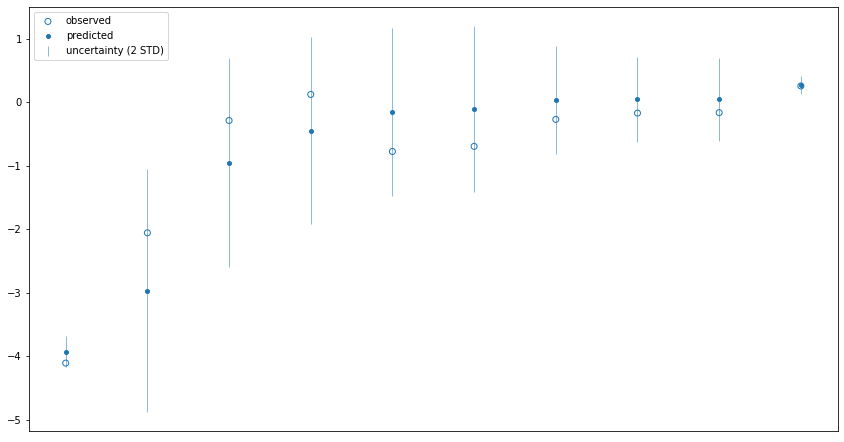

In [47]:
# check testing points
inference.plot()

In [48]:
# draw samples from the posterior distribution
y_mean, y_std = emulator.predict(x_test)
print(y_mean.shape)
print(y_std.shape)

(10,)
(10,)


In [49]:
y_samples = emulator.sample(x_test, n_draws=5)
print(y_samples.shape)

(5, 10)


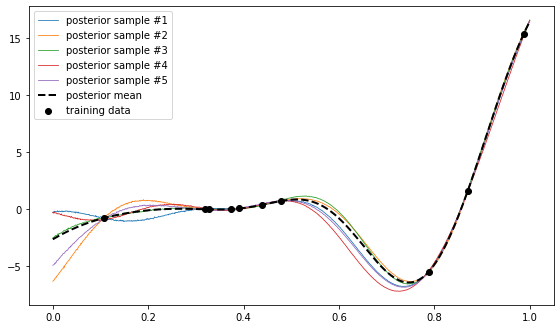

In [50]:
y_samples = emulator.sample(xx, n_draws=5)

fig, axis = plt.subplots(1, 1, figsize=(4*width/3, height/2))

for i, ys in enumerate(y_samples):
    axis.plot(xx, ys, lw=0.8, label=f"posterior sample #{i+1}", zorder=1)
    
axis.plot(xx, yy_mean, c="k", lw=2, ls="--", label="posterior mean", zorder=2)
axis.scatter(x_train, y_train, fc="k", ec="k", label="training data", zorder=2)

axis.legend(loc="best")
fig.tight_layout()
plt.show()